In [1]:
import numpy as np
import matplotlib.pyplot as plt

- **Herfindal index**
$$
\mathcal{H}(N) \equiv \sum_{i=1}^N (\frac{x_i}{\sum_{j=1}^N  x_j})^2 \in (0,1]
$$

- **Dynamic**
$$
\frac{d}{dt}Z_i = m Z_i + \eta_i(t) Z_i \quad i = 1 \sim N
$$

where for all i( i.i.d), $\langle \eta_i(t) \rangle=0$, $\langle  \eta_i(t)  \eta_i(s)\rangle = \frac{\sigma^2}{2 \tau_c}e^{-\frac{\lvert t - s \rvert}{\tau_c}}$, $\langle \eta_i^2(t) \rangle = \frac{\sigma^2}{2\tau_c}$. 　

Here we choose $\eta_i(t)$ to be the Ornstein-Uhlenbeck process :
$$
\frac{d\eta_i(t)}{dt} = - \frac{1}{\tau_c} x(t) + \sigma dB_t
$$

For simulation, we let $\varepsilon_i(t) \sim N(0,\sigma^2 dt)$, $\eta_i(0) \sim N(0, \frac{\sigma^2}{1-(1-\frac{dt}{\tau_c})^2})$ and
compute
$$
\eta_i(t+dt) = \eta_i(t) - \frac{dt}{\tau_c} \eta_i(t) + \varepsilon_i(t)
$$

#### Exponential decay of autocorrelation of O-U process

In [2]:
def OU(N,tau_c,sigma):
    dt = 0.01
    c = 1-dt/tau_c
    std = (sigma**2*dt/(1-c**2))**(1/2)
    eta_array=np.zeros(N+1)
    epsilon_array = np.random.normal(0,sigma*dt,N)
    eta_array[0]=np.random.normal(0,std)
    for n in range(1,N+1):
        eta_array[n] = c*eta_array[n-1]+epsilon_array[n-1]
    return eta_array

In [31]:
dt = 0.03
tau_c=1.1
sigma=0.1
c = 1-dt/tau_c
std = (sigma**2*dt**2/(1-c**2))**(1/2)
eta_array =OU(900000,tau_c,sigma)

In [32]:
std , np.std(eta_array[:]) , sigma**2/(1-c**2)

(0.01293371972754875, 0.0075424213809503595, 0.18586789554531524)

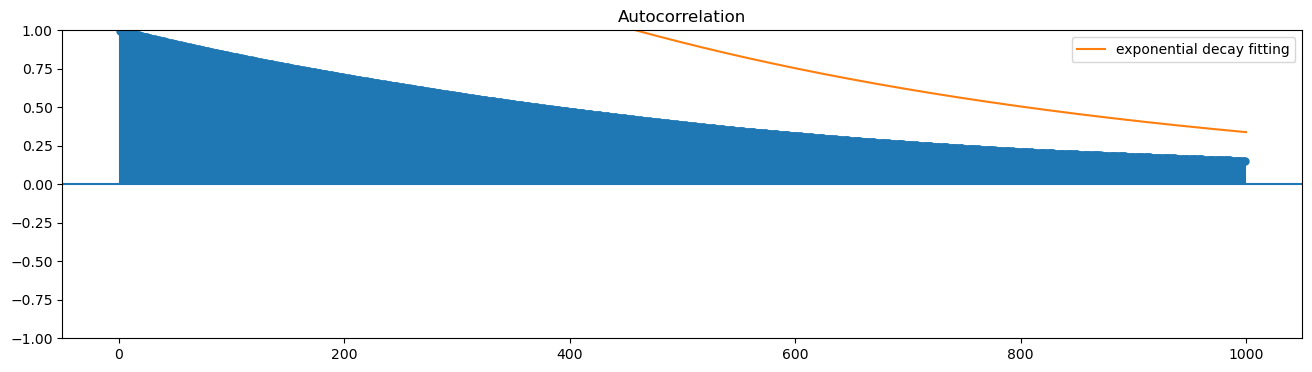

In [26]:

from statsmodels.graphics.tsaplots import plot_acf
ACF=plot_acf(eta_array , lags=np.arange(1,1000) ,alpha=None )
ACF.set_figwidth(16)
ACF.set_figheight(4)
    
T = np.linspace(0,1000,10000)
plt.plot(T,np.array([sigma**2/(1-(1-dt/tau_c)**2) * np.exp(-s*dt/tau_c) for s in T]) ,label="exponential decay fitting")
plt.legend()

#### Simulation

In [82]:
def Z_process(T,m,z_0,tau_c,sigma):
    dt = 0.01
    Z_array = np.ones(T+1)
    Z_array[0] = z_0
    eta_array = OU(T,tau_c,sigma)
    for i in range(1,T+1):
        ratio = 1+ (m+ (eta_array[i-1]+eta_array[i])/2 )*dt
        if ratio<0: #truncated when Z<0
            Z_array[i]=0
        else:
            Z_array[i] = ratio*Z_array[i-1]
    return Z_array


In [45]:
def H_index(Z_collection):
    H_array=np.zeros(len(Z_collection[0]))
    for s in range(len(Z_collection[0])):
        S = sum( Z_collection[:,s])
        if S==0:
            H_array[s]=0  #all die out => equally distributed
        else:
            H_array[s]= sum( (Z_collection[:,s]/ S)**2 )
    return H_array

Consider $m=2$, $\tau_c =2$, $Z_i(0)=1$ for all $i$, $dt=0.01$ and $\sigma=0.1$ for the simulation. The typical value( or expected value) of the  Herfindahl index is said to have a phase transition at $t_c = \frac{2 \ln N}{\sigma^2}$ from equally distributed state
to more concentrated state. The computation of expected value via Monte-Carol will take alot of time. Here we plot a realization of the Herfindahl index in time in the below.

In [71]:
N=10000
T= 10001
m=2
z_0=1
tau_c=2
sigma=0.1
H_collection_2 = np.empty((10,T),dtype=object )
for n in range(10):
    print(n)
    test=np.empty((N,T),dtype=object )
    for i in range(N):
        test[i,:] = Z_process(T-1,m,z_0,tau_c,sigma)
    H_collection_2[n]=H_index(test)

0
1
2
3
4
5
6
7
8
9


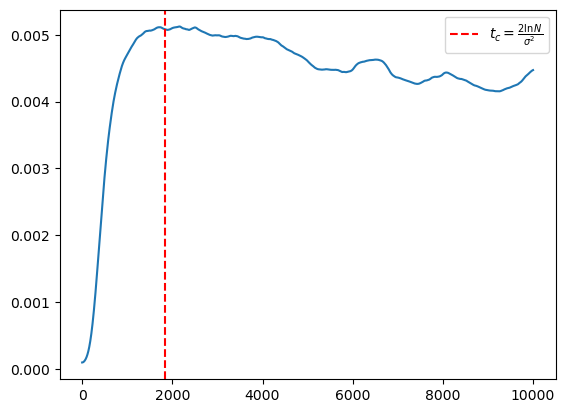

In [99]:
plt.plot( H_collection_2[4] )

plt.axvline(2*np.log(N)/(sigma**2) , color ='r' , ls='--',label=r'$t_c = \frac{2\ln N}{\sigma^2}$')
plt.legend()

In [20]:
np.cumsum(H_collection[0]+H_collection[1]+H_collection[2]+H_collection[3])/4

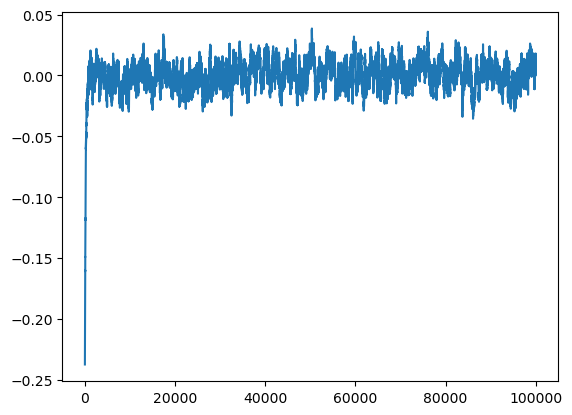

In [107]:
plt.plot(OU(100000,tau_c,sigma))

In [9]:
test

array([[1, 2, 2],
       [None, None, None]], dtype=object)

In [28]:
shiftedW = np.zeros(10)
W = np.arange(10)
shiftedW[1:] = W[:-1]

In [31]:
W[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [30]:
shiftedW

array([0., 0., 1., 2., 3., 4., 5., 6., 7., 8.])